In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba 
from numba import prange
from joint_QR import *

In [2]:
from typing import Union

# Generate some fake data

In [3]:
np.random.seed(0)

In [4]:
x_vals = np.arange(-0.99,1, 0.01)
y_vals_true = 0 + 0.5*x_vals + np.random.normal(0,0.5,len(x_vals))

In [5]:
len(y_vals_true)

199

## First Plot: Single sample for multiple tau

In [6]:
# Example X_vals and tau_vals
tau_vals = np.arange(0,1,0.05)[1:]



Text(0, 0.5, 'Y')

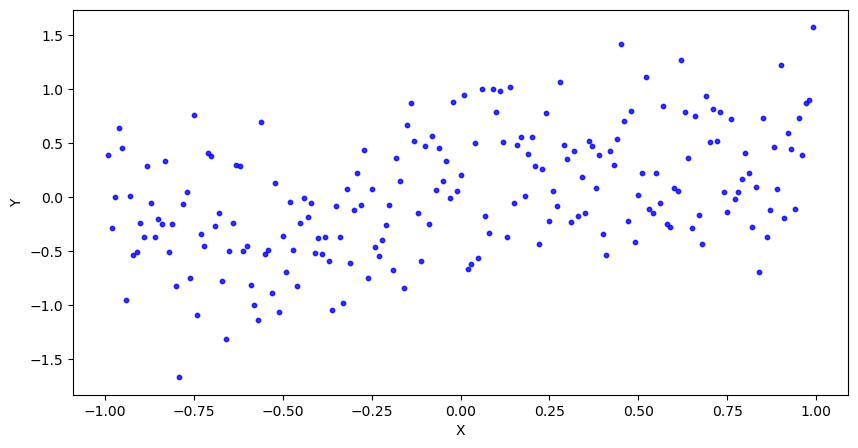

In [7]:
fig, ax = plt.subplots(figsize=(10,5))

ax.scatter(x_vals, y_vals_true, s=10, color='blue', alpha=0.8)
    
ax.set_xlabel('X')
ax.set_ylabel('Y')

# MCMC Sampling

- Block (Metropolis in Gibbs):
- Block 1: Eta Function components, GP, lambda and rho
- Block 2: Remaining, mu, gamma, sigma1 and sigma2

# MCMC Sampling Loop with Approximation

Setting priors for 
- W $\sim$ GP Thingy (Just draw from multviariate)?
- $\kappa^2 \sim  IG(3,1/3)$
- $\lambda^2 \sim Ga(5,1/10)$
- $\rho \sim Unif(0,1)$
- $\sigma_1, \sigma_2 \sim Ga(2,2)$
- $\mu \sim N(0,1)$
- $\gamma \sim N(0,1)$

Block metropolis with blocks
- W, $\kappa^2$, $\lambda^2$, $\rho$
-  $\sigma_1, \sigma_2, \mu, \gamma$

In [8]:
from scipy.stats import multivariate_normal, gamma
import time
from scipy.linalg import block_diag

In [46]:
step_sizes_1

array([0.8       , 0.74642639, 0.71676677, ..., 0.30581628, 0.30581424,
       0.3058122 ])

In [75]:
# Set MCMC Parameters
s = time.time()
n_steps = 15000
lol_cnt = 0

# Set adaptive metropolis step sizes
C_1= 1
lambda_step_size_1 = 3
alpha_step_size_1 = 0.3
step_sizes_1 = C_1/(np.arange(1,n_steps+10)**alpha_step_size_1)
a_target_1 = 0.4

C_2 = 1
lambda_step_size_2 = 3
alpha_step_size_2 = 0.3
step_sizes_2 = C_2/(np.arange(1,n_steps+10)**alpha_step_size_2)
a_target_2 = 0.4

# Set knot points for approx
tau_grid_expanded = np.arange(0,1.01,0.01)
tau_grid = np.arange(0.01,1.0,0.01)
knot_points_t = np.arange(0.1,1,0.1)
m = len(knot_points_t)  # no knots


# Calc covariance matrix 
knot_sub_ids = np.array(m*[0] + m*[1]).reshape(-1,1)
knot_points_t = np.concatenate([knot_points_t,
                            knot_points_t]).reshape(-1,1)

knot_points = np.hstack([knot_sub_ids, knot_points_t])

tau_input_test_0 = np.vstack([np.zeros(len(tau_grid)), tau_grid]).T
tau_input_test_1 = np.vstack([np.ones(len(tau_grid)), tau_grid]).T
tau_input = np.vstack([tau_input_test_0, tau_input_test_1])

tau_input_test_0_expanded = np.vstack([np.zeros(len(tau_grid_expanded)),
                                       tau_grid_expanded]).T
tau_input_test_1_expanded= np.vstack([np.ones(len(tau_grid_expanded)),
                                       tau_grid_expanded]).T

tau_input_expanded = np.vstack([tau_input_test_0_expanded,
                                tau_input_test_1_expanded])



#### Initialize variables

## GP Related hyperparameters
kappa_current = 3
rho_current = 0
lambd_current = 4

## Regression related parametrs
mu_current = 0
gamma_current = 1
sigma_1_current = 1
sigma_2_current = 1


#### W samples
# calc covariance matrix
cov_mat_knots_current = covariance_mat_single_var(knot_points,
                             kappa=kappa_current,
                             rho=rho_current,
                             lambd=lambd_current)

w_knot_points_current = np.random.multivariate_normal(np.zeros(m*2),
                                             cov_mat_knots_current)


# Generate sample of GP approx
w_approx_current = calc_knot_approx_v2(tau_input_expanded,
                                   np.arange(0.1,1,0.1),
                                   cov_mat_knots_current,
                                   w_knot_points_current,
                                   kappa_current,
                                   rho_current,
                                   lambd_current)



# Storage variables
w_approx_store = []
kappa_store = []
lambda_store = []
rho_store = []

sigma_1_store = []
sigma_2_store = []
mu_store = []
gamma_store = []


kappa_accept = 0
lambda_accept = 0
rho_accept= 0 
sigma_accept = 0
mu_accept = 0
gamma_accept = 0

### initialise adaptive metropolis

# Block 1
am_lamb_block1 = 0.5
log_am_lamb_block1 = np.log(am_lamb_block1)
am_cov_block1 = 0.5*block_diag(cov_mat_knots_current, np.eye(2))#np.eye(len(w_knot_points_current)+2)

mu_block1 = np.concatenate([w_knot_points_current,
                               np.array([kappa_current]),
                               np.array([lambd_current])])
                              # np.array([rho_current])])
    
# Block 2
am_lamb_block2 = 0.5
log_am_lamb_block2 = np.log(am_lamb_block2)
am_cov_block2 = np.diag([0.1,0.1,0.5,0.5])
mu_block2 = np.concatenate([np.array([mu_current]),
                               np.array([gamma_current]),
                               np.array([np.log(sigma_1_current),
                                         np.log(sigma_2_current)])])



rho_current = 0.5
checks = []
prop_check1 = []
prop_check2 = []
a_check = []

block_1_accept_cnts = 0
block_2_accept_cnts = 0
blk2_check = []

eps_1 = 1e-5
eps_2 = 1e-5

In [76]:
cov_store_2 = []
mu_block_store_2 =[]
am_params_store_2 = []
a_check2 = []

In [77]:
from scipy.stats import gamma

In [78]:
for mc_i in range(n_steps): 
    
    #print(mc_i)
    
    #### Generate Sample for W, kappa, tau, lamdba
    
    am_lamb_block1 = np.exp(log_am_lamb_block1)
    proposal_vec  = np.random.multivariate_normal(mu_block1,
                                                 am_lamb_block1*am_cov_block1+np.eye(len(mu_block1))*eps_1)
    
    w_knot_prop = proposal_vec[0:len(w_knot_points_current)]
    
    kappa_prop = proposal_vec[len(w_knot_points_current)]
    lambd_prop = proposal_vec[len(w_knot_points_current)+1]
    #log_rho_prop = proposal_vec[len(w_knot_points_current)+2]
    
    prop_check1.append(proposal_vec)
    
    rho_prop = 0.5#1/(1+e**log_rho_prop)
    
    cov_mat_knot_prop = covariance_mat_single_var(knot_points,
                             kappa=kappa_prop,
                             rho=rho_prop,
                             lambd=lambd_prop)
    
    # Update w_sample
    w_approx_prop = calc_knot_approx_v2(tau_input_expanded,
                                   np.arange(0.1,1,0.1),
                                   cov_mat_knot_prop,
                                   w_knot_prop,
                                   kappa_prop,
                                   rho_prop,
                                   lambd_prop)

    # Calc likelihood
    ll_prop = eval_ll(y_vals_true,
                      x_vals,
                      w_samples_1=w_approx_prop[0:101],
                      w_samples_2=w_approx_prop[101:],
                      sigma_1=sigma_1_current,
                      sigma_2=sigma_2_current,
                      tau_grid=tau_grid,
                      tau_grid_expanded=tau_grid_expanded,
                      mu=mu_current,
                      gamma=gamma_current,
                      base_quantile_mean=0.0,
                      base_quantile_sd=1.0,
                      base_quantile_v=1,
                      base_quantile_dist='norm')

    ll_curr = eval_ll(y_vals_true,
                      x_vals,
                      w_samples_1=w_approx_current[0:101],
                      w_samples_2=w_approx_current[101:],
                      sigma_1=sigma_1_current,
                      sigma_2=sigma_2_current,
                      tau_grid=tau_grid,
                      tau_grid_expanded=tau_grid_expanded,
                      mu=mu_current,
                      gamma=gamma_current,
                      base_quantile_mean=0.0,
                      base_quantile_sd=1.0,
                      base_quantile_v=1,
                      base_quantile_dist='norm')    

    checks.append((ll_prop, ll_curr))
    # Take metropolis step
    
    log_prior_prop = logpdf_mvn(w_knot_prop,np.zeros(m*2),cov_mat_knot_prop) +\
                     gamma.logpdf(1/kappa_prop**(2),  a=3, scale=1/3) +\
                     gamma.logpdf(lambd_prop**(2),  a=5, scale=1/10) 
    
    
    log_prior_current = logpdf_mvn(w_knot_points_current,np.zeros(m*2),cov_mat_knots_current) +\
                 gamma.logpdf(1/kappa_current**(2),  a=3, scale=1/3) +\
                 gamma.logpdf(lambd_current**(2),  a=5, scale=1/10) 
    
    
    
    """
    log_proposal_prop = multivariate_normal.logpdf(proposal_vec,
                                                  mu_block1,
                                                  am_lamb_block1*am_cov_block1,
                                                  allow_singular=True)
    """
    log_proposal_prop = logpdf_mvn(proposal_vec,
                                   mu_block1,
                                   am_lamb_block1*am_cov_block1+np.eye(len(mu_block1))*eps_1)
    
    current_vec = np.concatenate([w_knot_points_current,
                               np.array([kappa_current]),
                               np.array([lambd_current])])
    
    """
    log_proposal_current = multivariate_normal.logpdf(current_vec,
                                                  mu_block1,
                                                  am_lamb_block1*am_cov_block1)
    """
    log_proposal_current = logpdf_mvn(current_vec,
                               mu_block1,
                               am_lamb_block1*am_cov_block1+np.eye(len(mu_block1))*eps_1)
    
    
    a = np.exp(min(0,  (ll_prop + log_prior_prop + log_proposal_current) - \
                       (ll_curr + log_prior_current + log_proposal_prop) ))
    
    a_check.append(a)
    #print(a)
    if np.random.uniform(0,1) < a:
        w_knot_points_current = w_knot_prop
        kappa_current = kappa_prop
        lambd_current = lambd_prop
        kappa_current = kappa_prop
        rho_current = rho_prop
        
        block_1_accept_cnts += 1
    else: 
        w_knot_points_current = w_knot_points_current
        kappa_current = kappa_current
        lambd_current = lambd_current
        kappa_current = kappa_current
        rho_current = rho_current
    
    # Update w 
    w_approx_current = calc_knot_approx_v2(tau_input_expanded,
                                   np.arange(0.1,1,0.1),
                                   cov_mat_knots_current,
                                   w_knot_points_current,
                                   kappa_current,
                                   rho_current,
                                   lambd_current)
    
    
    cov_mat_knots_current = covariance_mat_single_var(knot_points,
                             kappa=kappa_current,
                             rho=rho_current,
                             lambd=lambd_current)
    
    # Update AM sampling parameters
    update_block = np.concatenate([w_knot_points_current,
                               np.array([kappa_current]),
                               np.array([lambd_current])])
                              # np.array([np.log(rho_current/(1-rho_current))])])
    

    
    # Adaptive metropolis update for block 1
    log_am_lamb_block1 = log_am_lamb_block1 + step_sizes_1[mc_i]*(a - a_target_1)
    #print(log_am_lamb_block1)
    mu_block1_update = mu_block1 + step_sizes_1[mc_i]*(update_block - mu_block1)
    
    am_cov_block1 =  am_cov_block1 + \
                    step_sizes_1[mc_i]*( (update_block - mu_block1).reshape(-1,1) @\
                                                  ((update_block - mu_block1).reshape(-1,1).T) - am_cov_block1)
    
    mu_block1 = mu_block1_update
    
    # Store generated variables
    w_approx_store.append(w_approx_current)
    kappa_store.append(kappa_current)
    lambda_store.append(lambd_current)
    
    
    
    
    
    #### Sample mu, gamma, sigma1 and sigma2  ####   
    am_lamb_block2 = np.exp(log_am_lamb_block2)
    proposal_vec2  = np.random.multivariate_normal(mu_block2,
                                                 am_lamb_block2*am_cov_block2+eps_2*np.eye(len(mu_block2)) )
    blk2_check.append((mu_block2, am_lamb_block2, am_cov_block2))

    mu_prop = proposal_vec2[0]
    gamma_prop = proposal_vec2[1]
    
    #sigma_1_prop = np.abs(proposal_vec2[2])#**2
    #sigma_2_prop = np.abs(proposal_vec2[3])#**2
    sigma_1_prop = np.exp(proposal_vec2[2])
    sigma_2_prop = np.exp(proposal_vec2[3])

    
    prop_check2.append((proposal_vec2, mu_block2))
    

    # Calc likelihood
    ll_prop = eval_ll(y_vals_true,
                      x_vals,
                      w_samples_1=w_approx_current[0:101],
                      w_samples_2=w_approx_current[101:],
                      sigma_1=sigma_1_prop,
                      sigma_2=sigma_2_prop,
                      tau_grid=tau_grid,
                      tau_grid_expanded=tau_grid_expanded,
                      mu=mu_prop,
                      gamma=gamma_prop,
                      base_quantile_mean=0.0,
                      base_quantile_sd=1.0,
                      base_quantile_v=1,
                      base_quantile_dist='norm')

    ll_curr = eval_ll(y_vals_true,
                      x_vals,
                      w_samples_1=w_approx_current[0:101],
                      w_samples_2=w_approx_current[101:],
                      sigma_1=sigma_1_current,
                      sigma_2=sigma_2_current,
                      tau_grid=tau_grid,
                      tau_grid_expanded=tau_grid_expanded,
                      mu=mu_current,
                      gamma=gamma_current,
                      base_quantile_mean=0.0,
                      base_quantile_sd=1.0,
                      base_quantile_v=1,
                      base_quantile_dist='norm')    

    checks.append((ll_prop, ll_curr))
    # Take metropolis step
    
    log_prior_prop = norm.logpdf(mu_prop,0,1) +\
                     norm.logpdf(gamma_prop,0,1) +\
                     gamma.logpdf(sigma_1_prop**2,  a=2, scale=1/2) +\
                     gamma.logpdf(sigma_2_prop**2,  a=2, scale=1/2) 
    
    
    log_prior_current = norm.logpdf(mu_current,0,1) +\
                        norm.logpdf(gamma_current,0,1) +\
                        gamma.logpdf(sigma_1_current**2,  a=2, scale=1/2) +\
                        gamma.logpdf(sigma_2_current**2,  a=2, scale=1/2) 
    
    """
    log_proposal_prop = multivariate_normal.logpdf(proposal_vec2,
                                                  mu_block2,
                                                  am_lamb_block2*am_cov_block2) \
                                                    - np.log(sigma_1_prop) \
                                                    - np.log(sigma_2_prop)
    """
    log_proposal_prop = logpdf_mvn(proposal_vec2,
                                  mu_block2,
                                  am_lamb_block2*am_cov_block2+np.eye(len(mu_block2))*eps_2) \
                                    - sigma_1_prop \
                                    - sigma_2_prop
   
    
    current_vec2 = np.concatenate([np.array([mu_current]),
                               np.array([gamma_current]),
                               np.array([np.log(sigma_1_current),
                                         np.log(sigma_2_current)])])
    
    """
    log_proposal_current = multivariate_normal.logpdf(current_vec2,
                                                  mu_block2,
                                                  am_lamb_block2*am_cov_block2) \
                                                    - np.log(sigma_1_current) \
                                                    - np.log(sigma_2_current)
    """
    log_proposal_current = logpdf_mvn(current_vec2,
                                      mu_block2,
                                      am_lamb_block2*am_cov_block2+np.eye(len(mu_block2))*eps_2) \
                                        - sigma_1_current \
                                        - sigma_2_current
                                                    
    
    #if (ll_prop + log_prior_prop + log_proposal_current) > 0:
    #    break
        
    a = np.exp(min(0,  (ll_prop + log_prior_prop + log_proposal_current) \
                     - (ll_curr +log_prior_current + log_proposal_prop) ))
    
    a_check2.append((a, 
                     ll_prop + log_prior_prop + log_proposal_current,
                     ll_curr +log_prior_current + log_proposal_prop))
    
    #print(a)
    if np.random.uniform(0,1) < a:
        mu_current = mu_prop
        gamma_current = gamma_prop
        sigma_1_current = sigma_1_prop
        sigma_2_current = sigma_2_prop
        
        block_2_accept_cnts += 1
    else: 
        mu_current = mu_current
        gamma_current = gamma_current
        sigma_1_current = sigma_1_current
        sigma_2_current = sigma_2_current
    
    
    sigma_1_store.append(sigma_1_current)
    sigma_2_store.append(sigma_2_current)
    mu_store.append(mu_current)
    gamma_store.append(gamma_current)
    
    # Update AM block 2 sampling parameters
    update_block_2 = np.concatenate([np.array([mu_current]),
                               np.array([gamma_current]),
                               np.array([np.log(sigma_1_current),
                                         np.log(sigma_2_current)])])

    
    # Adaptive metropolis update for block 1
    log_am_lamb_block2 = log_am_lamb_block2 + step_sizes_2[mc_i]*(a - a_target_2)
    #print(log_am_lamb_block1)
    mu_block2_update = mu_block2 + step_sizes_2[mc_i]*(update_block_2 - mu_block2)
    
    am_cov_block2 =  am_cov_block2 + \
                    step_sizes_2[mc_i]*( (update_block_2 - mu_block2).reshape(-1,1) @\
                                                  ((update_block_2 - mu_block2).reshape(-1,1).T) - am_cov_block2)
    
    mu_block2 = mu_block2_update.copy()
    cov_store_2.append(am_cov_block2)
    if mc_i%100 == 0:
        e = time.time()
        print('Step: ', mc_i, ' Time Taken: ', e-s)
        s = time.time()
        

Step:  0  Time Taken:  2.9972379207611084
Step:  100  Time Taken:  1.2046968936920166
Step:  200  Time Taken:  1.1928081512451172
Step:  300  Time Taken:  1.1208150386810303
Step:  400  Time Taken:  1.1161410808563232
Step:  500  Time Taken:  1.10178804397583
Step:  600  Time Taken:  1.2089898586273193
Step:  700  Time Taken:  1.2479209899902344
Step:  800  Time Taken:  1.3356022834777832
Step:  900  Time Taken:  1.3252148628234863
Step:  1000  Time Taken:  1.1434056758880615
Step:  1100  Time Taken:  1.5308570861816406
Step:  1200  Time Taken:  1.3500621318817139
Step:  1300  Time Taken:  1.1066980361938477
Step:  1400  Time Taken:  1.1477997303009033
Step:  1500  Time Taken:  1.1256556510925293
Step:  1600  Time Taken:  1.1108479499816895
Step:  1700  Time Taken:  1.0863900184631348
Step:  1800  Time Taken:  1.1283559799194336
Step:  1900  Time Taken:  1.2339799404144287
Step:  2000  Time Taken:  1.3105661869049072
Step:  2100  Time Taken:  1.0845890045166016
Step:  2200  Time Taken:

In [54]:
logpdf_mvn(current_vec2,
          mu_block2,
          am_lamb_block2*am_cov_block2+np.eye(len(mu_block2))*1e-2)

-1.0988646430160802

In [55]:
am_lamb_block2*am_cov_block2

array([[ 12.40764275, -10.51555741,   5.18183379,   0.69399724],
       [-10.51555741,   9.24370651,  -4.59762931,  -1.15949015],
       [  5.18183379,  -4.59762931,   2.30329082,   0.6449694 ],
       [  0.69399724,  -1.15949015,   0.6449694 ,   1.02331241]])

# Chain Eval

## Kappa and Lambda

Text(0.5, 1.0, 'Lambda Trace Plot')

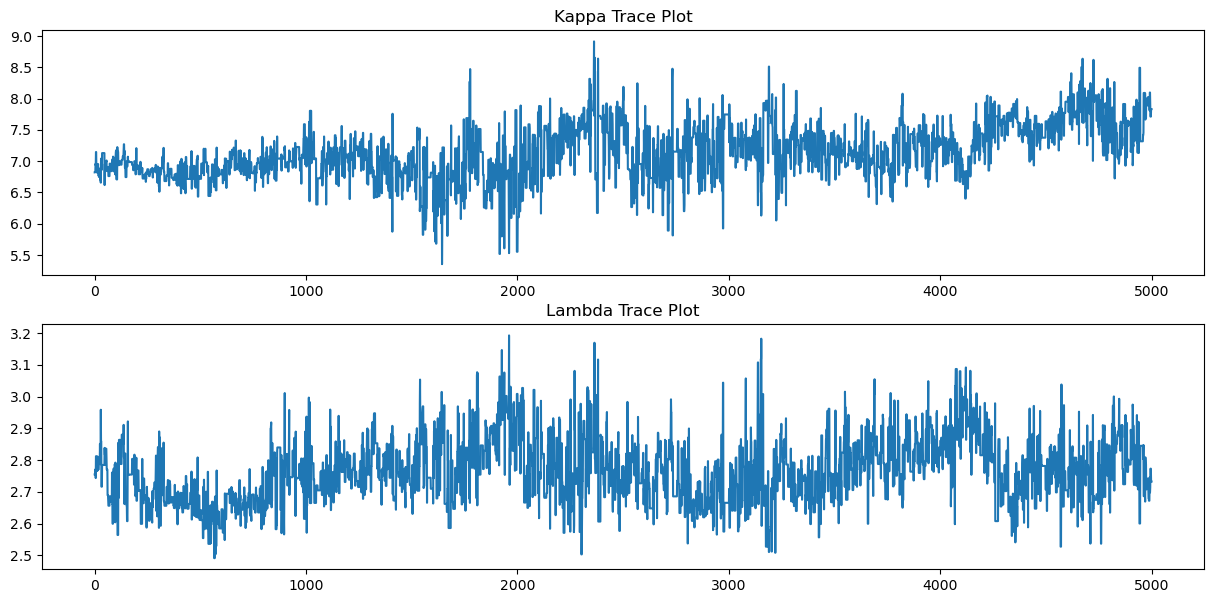

In [62]:
fig, ax = plt.subplots(2,1,figsize=(15,7))

n_burn_in = 10000

ax[0].plot(kappa_store[n_burn_in:])
ax[1].plot(lambda_store[n_burn_in:])

ax[0].set_title('Kappa Trace Plot')
ax[1].set_title('Lambda Trace Plot')

## Mu Gamma Sigmas

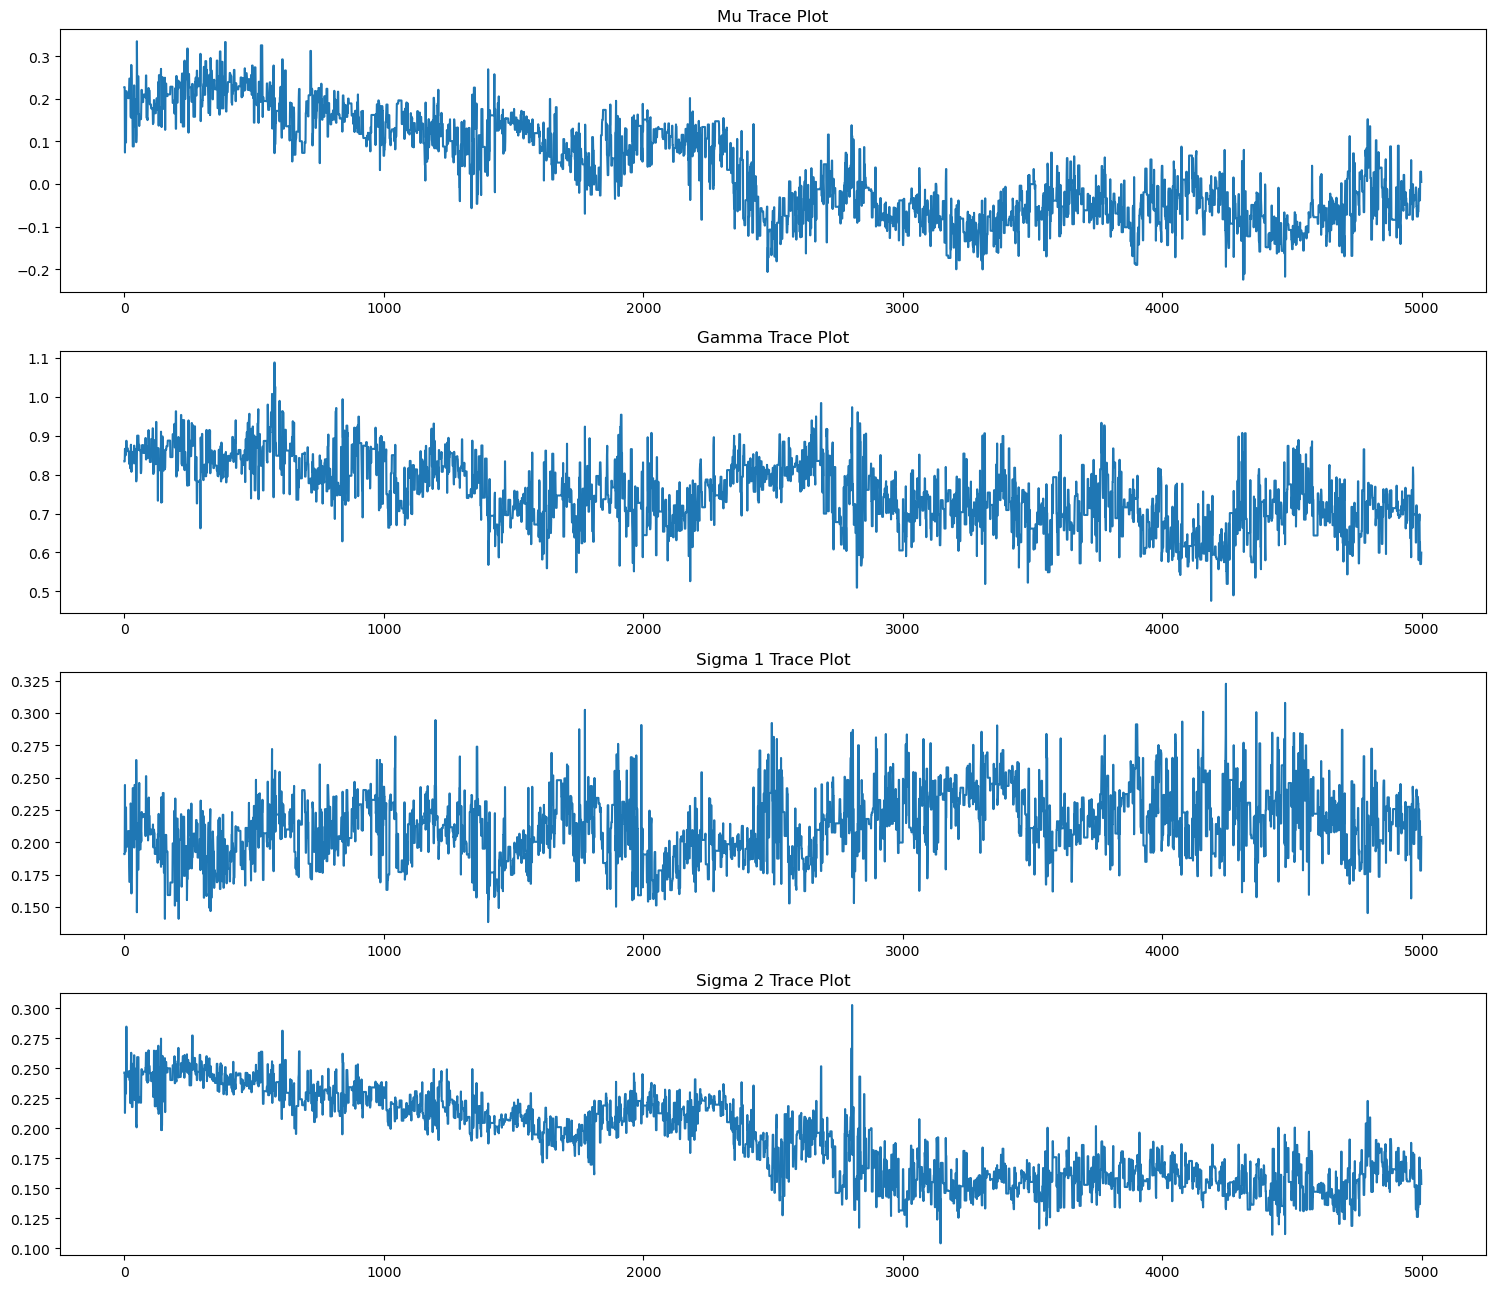

In [63]:
fig, ax = plt.subplots(4,1,figsize=(15,13))

ax[0].plot(mu_store[n_burn_in:])
ax[1].plot(gamma_store[n_burn_in:])
ax[2].plot(sigma_1_store[n_burn_in:])
ax[3].plot(sigma_2_store[n_burn_in:])

ax[0].set_title('Mu Trace Plot')
ax[1].set_title('Gamma Trace Plot')
ax[2].set_title('Sigma 1 Trace Plot')
ax[3].set_title('Sigma 2 Trace Plot')


plt.tight_layout()

## Inferred Beta 0 Beta 1 at various tau levels

In [64]:
from typing import List

In [65]:
def generate_beta_samples(tau_input: float,
                          tau_grid: np.ndarray,
                          w_approx_store: List[np.ndarray],
                          mu_store: List[float],
                          gamma_store: List[float],
                          sigma_1_store: List[float],
                          sigma_2_store: List[float]):

    beta_0_store = []
    beta_1_store = []

    for i in range(0,len(w_approx_store)):

        w_samp = w_approx_store[i]
        w1_samp = w_samp[0:101]
        w2_samp = w_samp[101:]

        mu_samp = mu_store[i]
        gamma_samp = gamma_store[i]
        sigma_1_samp = sigma_1_store[i]
        sigma_2_samp = sigma_2_store[i]


        eta_1_samp = eta_function_i_vector(tau_input=np.array([tau_input]),
                                             w_vals=w1_samp,
                                             tau_grid=tau_grid,
                                             mean=0.0,
                                             sd=1.0,
                                             v=1,
                                             sigma=sigma_1_samp,
                                             dist='norm')[0]


        eta_2_samp = eta_function_i_vector(tau_input=np.array([tau_input]),
                                             w_vals=w2_samp,
                                             tau_grid=tau_grid,
                                             mean=0.0,
                                             sd=1.0,
                                             v=1,
                                             sigma=sigma_2_samp,
                                             dist='norm')[0]


        beta_0_samp = mu_samp + (eta_1_samp + eta_2_samp)/2
        beta_1_samp = gamma_samp + (eta_2_samp - eta_1_samp)/2

        beta_0_store.append(beta_0_samp)
        beta_1_store.append(beta_1_samp)
        
    return beta_0_store, beta_1_store

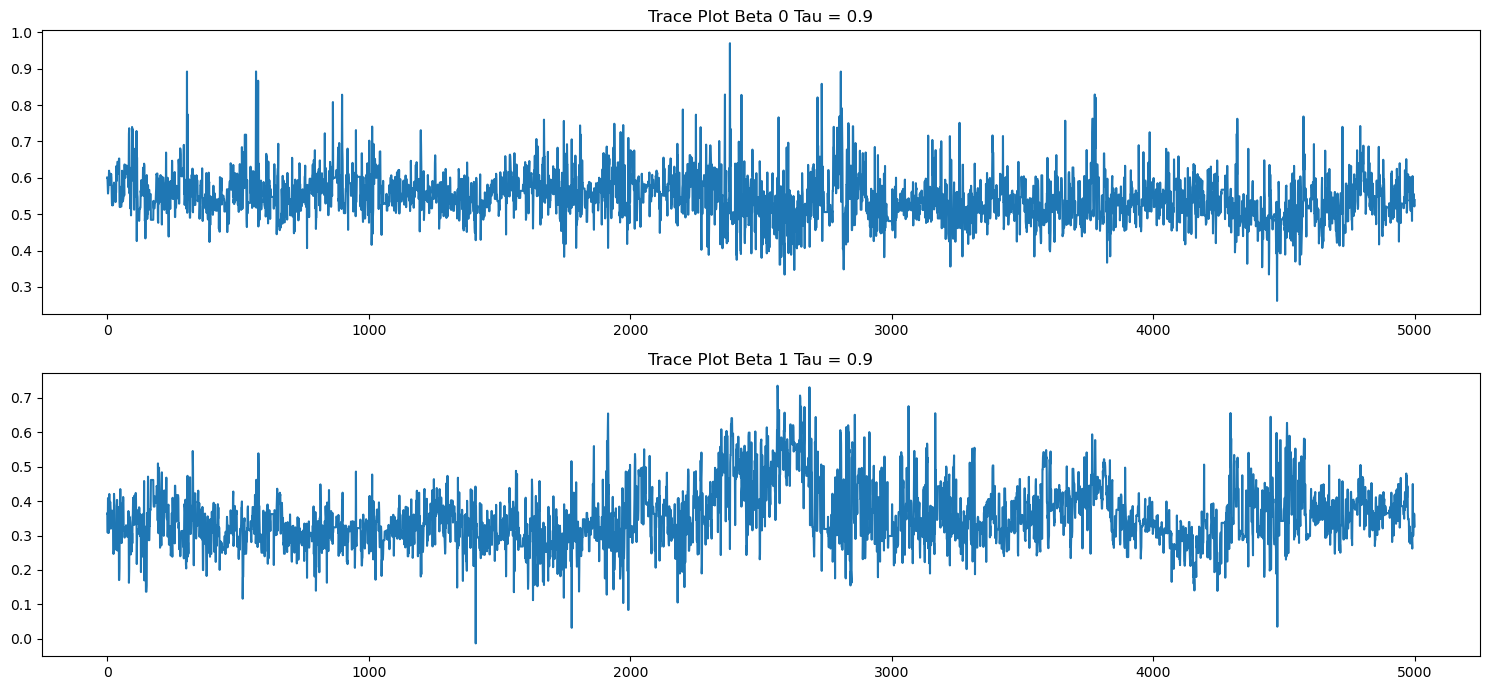

In [66]:
fig,ax = plt.subplots(2,1, figsize=(15,7))

input_tau = 0.9

beta_0_samps, beta_1_samps = generate_beta_samples(tau_input=input_tau,
                                                  tau_grid=tau_grid_expanded,
                                                  w_approx_store=w_approx_store,
                                                  mu_store=mu_store,
                                                  gamma_store=gamma_store,
                                                  sigma_1_store=sigma_1_store,
                                                  sigma_2_store=sigma_2_store)

ax[0].plot(beta_0_samps[n_burn_in:])
ax[1].plot(beta_1_samps[n_burn_in:])

ax[0].set_title('Trace Plot Beta 0 Tau = '+str(input_tau))
ax[1].set_title('Trace Plot Beta 1 Tau = '+str(input_tau))
plt.tight_layout()

Plot Example lines

In [69]:
y_pred_samples = np.array([b0 + b1*x_vals for b0,b1 in zip(beta_0_samps, beta_1_samps)])
y_pred_samples = y_pred_samples[n_burn_in:]

/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_52660/18142984.py:1: RuntimeWarning: invalid value encountered in add
  y_pred_samples = np.array([b0 + b1*x_vals for b0,b1 in zip(beta_0_samps, beta_1_samps)])


In [70]:
beta_0_samps[n_burn_in:]

[0.6008547874350822,
 0.6008547874350822,
 0.5817661430657977,
 0.5569268408090012,
 0.5664219752880826,
 0.5809389403868631,
 0.5967406704021547,
 0.6196745615824214,
 0.5828098403426931,
 0.5806345695988049,
 0.5806345695988049,
 0.6108154527086394,
 0.6116614583256796,
 0.5910849115562706,
 0.6039687229181921,
 0.6106164402704549,
 0.6016499002618291,
 0.563247175730444,
 0.5300620490900679,
 0.5244783234927414,
 0.5345732083149669,
 0.5246390910520383,
 0.5246390910520383,
 0.5322303430267118,
 0.5750965089928677,
 0.5810151386241835,
 0.5868581140110538,
 0.5744670011236519,
 0.5415209445593455,
 0.5727433136852157,
 0.5707191618409024,
 0.5767130123458656,
 0.533454328672656,
 0.5592913182182249,
 0.5592913182182249,
 0.6324179693970255,
 0.591424427869411,
 0.6286943852180147,
 0.6286943852180147,
 0.6440614362443182,
 0.6440614362443182,
 0.6440614362443182,
 0.6440614362443182,
 0.6440614362443182,
 0.6114141576040295,
 0.6530574654968321,
 0.6530574654968321,
 0.5330649264334

Text(0, 0.5, 'Y')

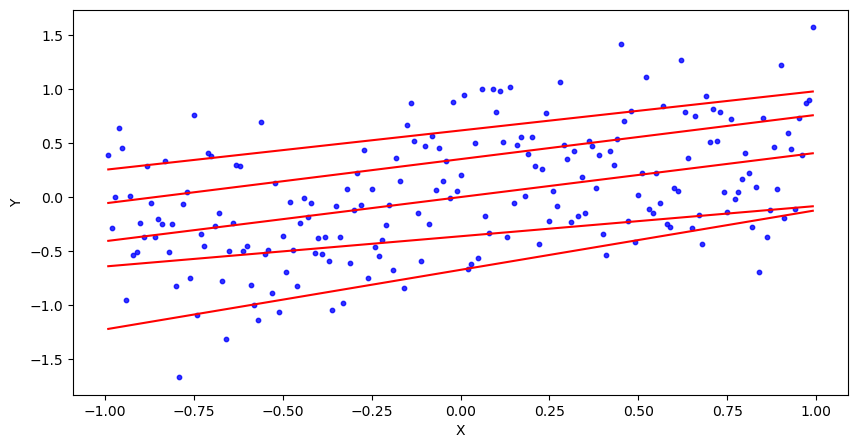

In [71]:
fig, ax = plt.subplots(figsize=(10,5))

ax.scatter(x_vals, y_vals_true, s=10, color='blue', alpha=0.8)

#sample_quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
sample_quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]

for sq in sample_quantiles:
    
    beta_0_samps, beta_1_samps = generate_beta_samples(tau_input=sq,
                                                      tau_grid=tau_grid_expanded,
                                                      w_approx_store=w_approx_store,
                                                      mu_store=mu_store,
                                                      gamma_store=gamma_store,
                                                      sigma_1_store=sigma_1_store,
                                                      sigma_2_store=sigma_2_store)
    
    y_pred_samples = np.array([b0 + b1*x_vals for b0,b1 in zip(beta_0_samps, beta_1_samps)])
    y_pred_samples = y_pred_samples[n_burn_in:]
    ax.plot(x_vals, y_pred_samples.mean(0), color='red')


ax.set_xlabel('X')
ax.set_ylabel('Y')

In [141]:
lol_X = np.array([[1,0,0],
                  [1,0,0],
                  [1,0,0],
                  [0,1,0],
                  [0,1,0],
                  [0,1,0],
                  [0,0,1],
                  [0,0,1],
                  [0,0,1]] )

In [144]:
lol_X.T @ lol_X

array([[3, 0, 0],
       [0, 3, 0],
       [0, 0, 3]])

In [145]:
np.linalg.inv(lol_X.T @ lol_X)

array([[0.33333333, 0.        , 0.        ],
       [0.        , 0.33333333, 0.        ],
       [0.        , 0.        , 0.33333333]])